In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import os
import sys

In [2]:
sys.path.append(os.path.abspath('../scripts'))

In [3]:
from time_series import *

## Loading the data

In [4]:
df = pd.read_csv('../data/tsla.csv')

### making the date column as index

In [5]:
df['Date'] = pd.to_datetime(df['Date'])  
df.set_index('Date', inplace=True)     

## Splitting the data into training and testing sets

In [6]:
train, test = split_data(df['Close'])

2024-11-13 15:21:44,125 - INFO - Data split into train and test sets successfully.


### choosing the best parameter for SARIMA model

In [7]:
# Seasonal auto_arima to find the best parameters
stepwise_model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=12.01 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12376.818, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12375.531, Time=1.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12376.009, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12375.317, Time=0.07 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=12376.983, Time=1.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=12377.355, Time=0.88 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=12369.981, Time=1.73 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=12348.776, Time=6.02 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=12346.777, Time=3.60 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=12345.613, Time=4.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=12347.601, Time=6.83 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=12368.841, Time=2.11 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=12346.729, Time=6.54 sec
 ARIMA(1,1

## Training SARIMA model

In [8]:
# Use the best parameters from auto_arima
p, d, q = stepwise_model.order
P, D, Q, m = stepwise_model.seasonal_order

# Fit the SARIMA model
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)


c:\Time-Series-Portfolio-Optimization\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Time-Series-Portfolio-Optimization\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Forecasting the Test Set

c:\Time-Series-Portfolio-Optimization\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Time-Series-Portfolio-Optimization\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


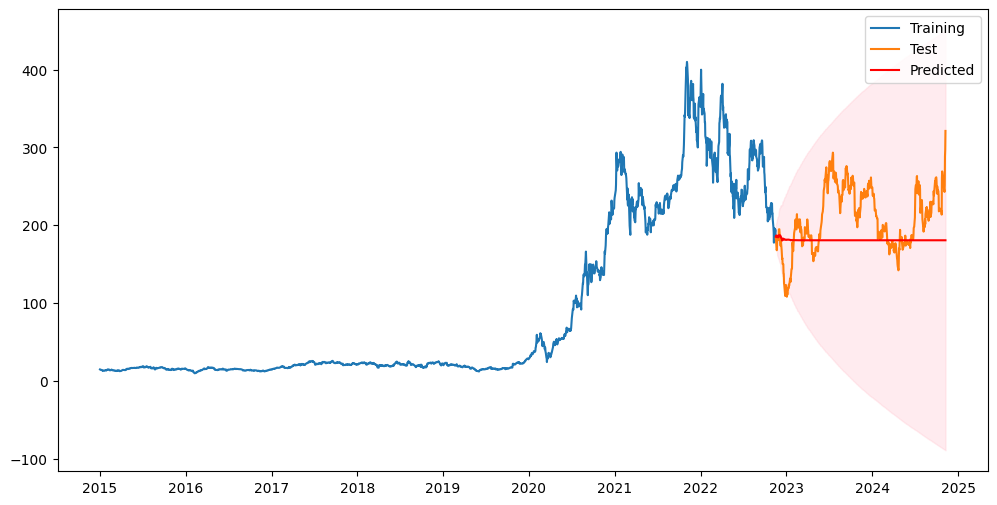

In [9]:
# Forecast for the test period
forecast = sarima_result.get_forecast(steps=len(test))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the forecasted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Training")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, predicted_mean, label="Predicted", color="red")
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

## Evaluating the Model

In [10]:
# Calculate evaluation metrics
mae = mean_absolute_error(test, predicted_mean)
rmse = np.sqrt(mean_squared_error(test, predicted_mean))
mape = mean_absolute_percentage_error(test, predicted_mean)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")


Mean Absolute Error (MAE): 38.48307030501455
Root Mean Squared Error (RMSE): 48.55506701017008
Mean Absolute Percentage Error (MAPE): 0.17451260686558123
